In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np

my_data = pd.read_csv('train.csv')

# Тестовое задание - Елькин СВ

### загрузим данные, посмотрим, что там

In [58]:
my_data

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7
...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23T12:54:35,Dabe,setting hostname,1
315,sensor,a3f5b753,2020-03-23T12:30:52,Dabe,heralding default dockerfile,2
316,sensor,e8155942,2020-03-23T11:27:40,Dabe,unnesserity /data path permissions setting,3
317,sensor,e748af51,2020-03-23T11:20:50,Dabe,added trapconductor,1


### взглянем, что как распределены баги в репозиториях

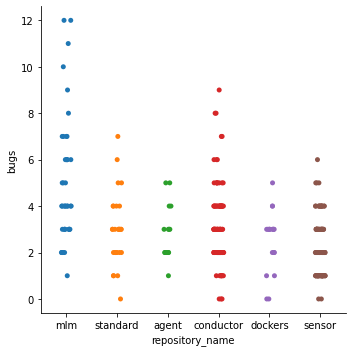

In [60]:
sns.catplot(x='repository_name',
            y='bugs',
            data=my_data);

### как связано количество багов и авторов

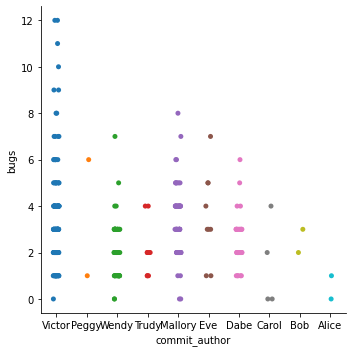

In [61]:
sns.catplot(x='commit_author',
            y='bugs',
            data=my_data);

### глянем, как связаны авторы и баги, подсветив репозитории

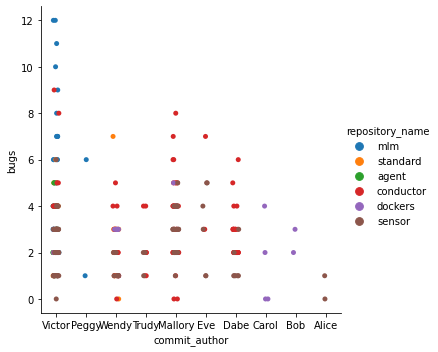

In [62]:
sns.catplot(x='commit_author',
            y='bugs',
            hue='repository_name',
            data=my_data);

## Что мы имеем и что можно предположить
#### Я предположу, что можно построить модель линейной регрессии - предположить значение параметра bugs по введенным параметрам
**Сложности** <br>
1 - почти все параметры - категориальные признаки <br>
2 - признаков несколько - какие выбрать

## Каков план
Я буду тестировать гипотезу, что на количество багов могут влиять такие факторы как "автор" и "репозиторий" <br>
Первым делом применим встроеный метод one-hot encoding.


In [63]:
from sklearn.preprocessing import LabelBinarizer

In [64]:
repository_to_vector = LabelBinarizer()
repository_to_vector.fit(my_data['repository_name'])
transformed = repository_to_vector.transform(my_data['repository_name'])
new_df = pd.DataFrame(transformed)
my_data = pd.concat([my_data, new_df], axis=1).drop(['repository_name'], axis=1)

In [65]:
commit_to_vector = LabelBinarizer()
commit_to_vector.fit(my_data['commit_author'])
transformed = commit_to_vector.transform(my_data['commit_author'])
new_df = pd.DataFrame(transformed)
my_data = pd.concat([my_data, new_df], axis=1).drop(['commit_author'], axis=1)

### перемешаем данные - будет полезно при обучении

In [66]:
my_data = my_data.sample(frac = 1) 
my_data

,commit_hash,commit_date,commit_message,bugs,0,1,2,3,4,5,0,1,2,3,4,5,6,7,8,9
179,f70f35c5,2020-03-20T10:24:33,return simple OK,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
89,59efac16,2020-06-10T10:16:27,add log cleaner,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
229,14379e78,2020-05-08T13:27:51,Added docker auth config,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
167,2ac97ed6,2020-03-23T10:44:12,logs path,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
106,5b6e921e,2020-05-01T13:28:30,rsplit не переворачивает список,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,9950eb18,2020-04-30T09:32:01,acl права в update.sh,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
82,3ce97d83,2020-05-19T18:33:05,Исправления с тестами,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
209,42374e44,2020-05-12T09:16:45,added composes backup,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
112,381d714a,2020-04-30T13:01:36,"права ему не нравятся, значит",4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Выкинем другие столбцы, кроме "багов"

In [67]:
my_data = my_data.drop(['commit_hash','commit_date','commit_message'], axis=1)

### Посмотрим, что получилось

In [68]:
my_data

,bugs,0,1,2,3,4,5,0,1,2,3,4,5,6,7,8,9
179,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
89,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
229,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
167,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
106,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
82,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
209,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
112,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


###  Начнем строить нашу модель - добавим библиотеку и сделаем тренировочную и тестовую выборку

In [69]:
from sklearn.linear_model import LinearRegression

In [70]:
model = LinearRegression(fit_intercept=True)

In [71]:
checker = my_data['bugs']

In [72]:
my_data.drop(['bugs'], axis=1)

,0,1,2,3,4,5,0,1,2,3,4,5,6,7,8,9
179,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
89,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
229,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
167,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
106,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
82,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
209,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
112,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [73]:
train_data = my_data[:-45]
train_label = checker[:-45]
test_data = my_data[-45:]
test_label = checker[-45:]

### Протренируем нашу модель

In [74]:
model.fit(train_data, train_label)

LinearRegression()

In [75]:
model.intercept_

3.1086244689504383e-15

In [76]:
model.coef_

array([ 1.00000000e+00, -5.86719263e-17,  2.14215312e-17, -3.31737137e-17,
       -1.92504072e-17,  6.51497104e-17,  1.46856270e-17, -4.75217249e-17,
       -3.80292196e-17, -4.13223902e-17,  4.34167680e-16,  2.10829394e-17,
        1.98906541e-18, -6.89739331e-17, -5.52627115e-17, -1.40068191e-16,
       -2.21192289e-17])

### Смещение и веса выстроены. Проверим, насколько хорошо это нам получилось
Для этого будем использовать *коэффициент детерминации* - он же $ R^2 $ - чем ближе к 1, тем точнее

In [77]:
from sklearn.metrics import r2_score

In [78]:
predicted_data = model.predict(test_data)

In [79]:
r2_score(predicted_data, test_label)

1.0

### Данные удалось отлично описать - значит данные жестко детерминированы
#### Давайте посмотрим, что похожи ли последние 10 предсказаных багов и то, как в реальности даны

In [80]:
predicted_data[-10:]

array([2.00000000e+00, 3.03412837e-15, 4.00000000e+00, 2.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 2.00000000e+00, 2.00000000e+00,
       4.00000000e+00, 1.00000000e+00])

In [81]:
test_label[-10:]

104    2
201    0
105    4
107    2
75     3
249    3
82     2
209    2
112    4
95     1
Name: bugs, dtype: int64

### На все уточняющие вопросы готов ответить)